Setup

In [1]:
import tensorflow as tf
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Image settings

In [ ]:
import cv2
import imghdr

In [4]:
data_dir = 'imgdata'

In [5]:
img_ext = 'png'

Loading Data

In [6]:
import numpy as np
from matplotlib import pyplot as plt

In [7]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 343 files belonging to 2 classes.


In [8]:
data_iterator = data.as_numpy_iterator()

In [9]:
batch = data_iterator.next()

In [10]:
#images as np array
batch[0].shape

(32, 256, 256, 3)

In [11]:
# class 0 = hawker
# class 1 = not hawker
batch[1]

array([0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0], dtype=int32)

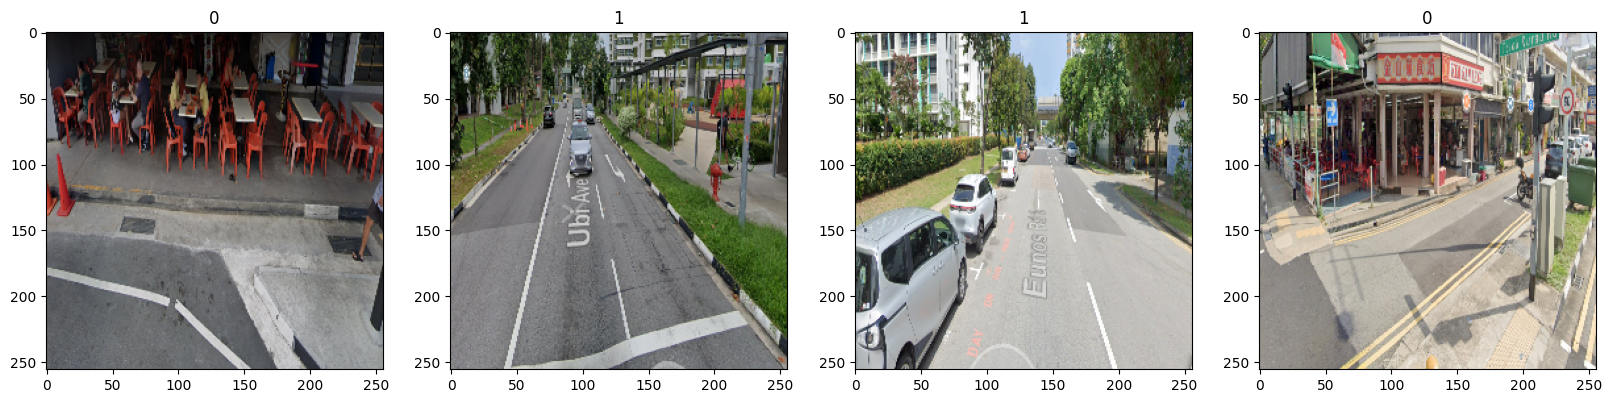

In [12]:
fig,ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Preprocess Data

In [13]:
batch[0].max()

np.float32(255.0)

In [14]:
#scaling data from 0 - 255 to 0 - 1
data = data.map(lambda x,y: (x/255,y))

In [15]:
data.as_numpy_iterator().next()[0].min()

np.float32(0.0)

In [16]:
scaled_iterator = data.as_numpy_iterator()

In [17]:
batch = scaled_iterator.next()

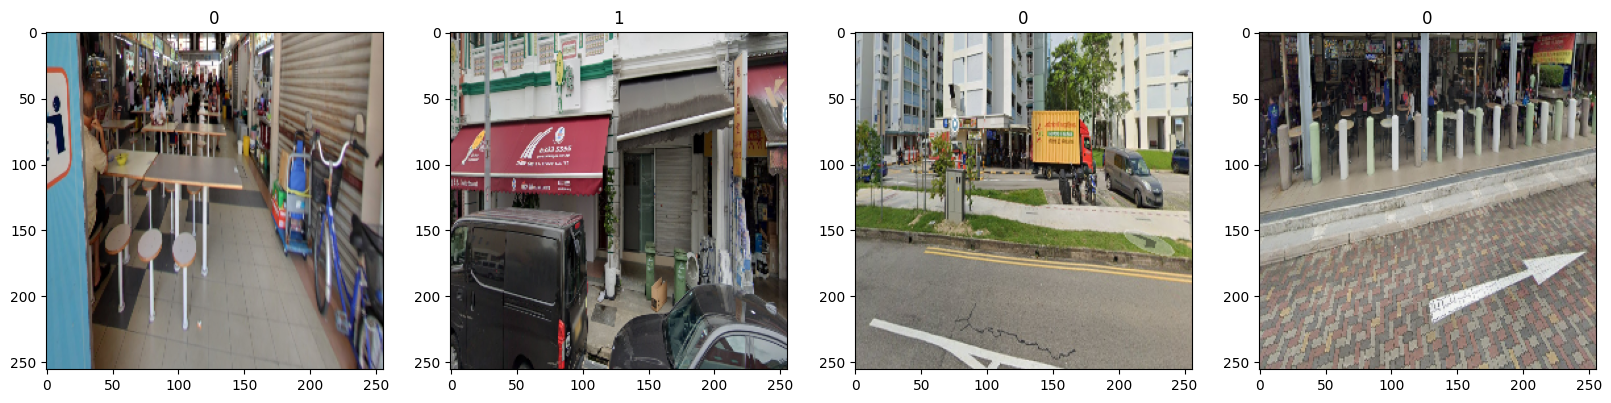

In [18]:
fig,ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

Splitting Data into training, validation and testing

In [41]:
len(data)

11

In [43]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)+1
test_size = int(len(data)*0.1)

train_size, val_size, test_size

(7, 3, 1)

In [44]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [45]:
len(test)

1

Model

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [47]:
model = Sequential()

In [48]:
#input img into convolution layer with 16 filters (nodes) with 3x3 in size and stride of 1 activated by relu function
model.add(Conv2D(16, (3,3), 1, activation="relu", input_shape=(256,256,3)))
#takes max relu values and returns it
model.add(MaxPooling2D())

#layer 2
model.add(Conv2D(32, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

#layer 3
model.add(Conv2D(32, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

#layer 4
model.add(Conv2D(16, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

#flatten and condense for Dense layer
model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [49]:
#compile model with adam optimizer, 
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [50]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 822,289 (3.14 MB)

 Trainable params: 822,289 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

Training

In [51]:
#logging of model training
logdir = 'logs'

In [52]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [53]:
hist = model.fit(train, epochs=30, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.5925 - loss: 0.6747 - val_accuracy: 0.5521 - val_loss: 0.6772
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.6281 - loss: 0.6708 - val_accuracy: 0.6146 - val_loss: 0.6498
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.6413 - loss: 0.6607 - val_accuracy: 0.6250 - val_loss: 0.5855
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.6490 - loss: 0.6058 - val_accuracy: 0.6771 - val_loss: 0.5849
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.6300 - loss: 0.6664 - val_accuracy: 0.7188 - val_loss: 0.6036
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.7098 - loss: 0.5910 - val_accuracy: 0.8542 - val_loss: 0.4662
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.6919 - loss: 0.5666 - val_accuracy: 0.7708 - val_loss: 0.4908
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.7149 - loss: 0.5303 - val_accuracy: 0.8021 - val_loss:

In [54]:
hist.history

{'accuracy': [0.6026785969734192,
  0.5892857313156128,
  0.6517857313156128,
  0.6383928656578064,
  0.6830357313156128,
  0.6964285969734192,
  0.7053571343421936,
  0.7589285969734192,
  0.7901785969734192,
  0.7366071343421936,
  0.7991071343421936,
  0.8348214030265808,
  0.8616071343421936,
  0.8482142686843872,
  0.8526785969734192,
  0.9241071343421936,
  0.90625,
  0.9107142686843872,
  0.9151785969734192,
  0.9508928656578064,
  0.9598214030265808,
  0.9732142686843872,
  0.9285714030265808,
  0.9375,
  0.9419642686843872,
  0.9821428656578064,
  0.96875,
  0.9866071343421936,
  1.0,
  0.9955357313156128],
 'loss': [0.6739115118980408,
  0.6758648753166199,
  0.6609859466552734,
  0.6092297434806824,
  0.6441019177436829,
  0.5822158455848694,
  0.559382438659668,
  0.4982112944126129,
  0.434883177280426,
  0.4862114489078522,
  0.44834598898887634,
  0.40704694390296936,
  0.31240779161453247,
  0.32426080107688904,
  0.3166499137878418,
  0.25302621722221375,
  0.243296995

Plot Performance

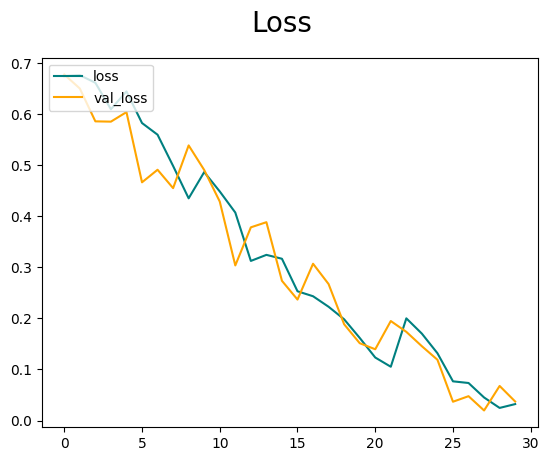

In [55]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color='orange',label = 'val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc="upper left")
plt.show()

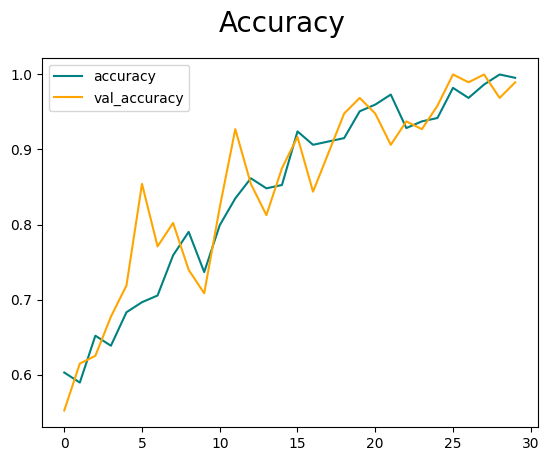

In [56]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color='orange',label = 'val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc="upper left")
plt.show()

Evaluate Model's Performance

In [34]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [57]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [58]:
for batch in test.as_numpy_iterator():
    x, y = batch
    yhat = model.predict(x)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


In [59]:
print("Precision: ", pre.result().numpy())
print("Recall: ", re.result().numpy())
print("Accuracy: ", acc.result().numpy())

Precision:  1.0
Recall:  1.0
Accuracy:  1.0


Test

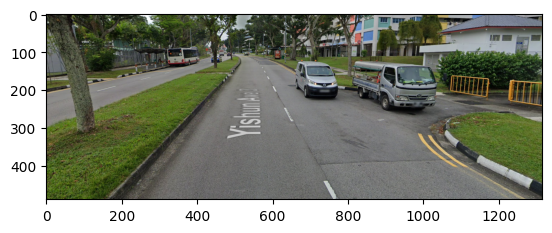

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[0.9991267]]
not hawker


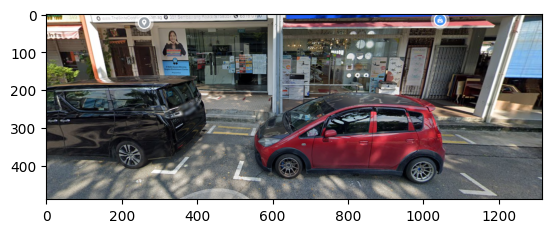

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[0.9976711]]
not hawker


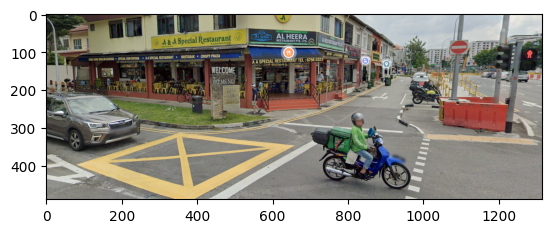

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[0.13099247]]
Hawker


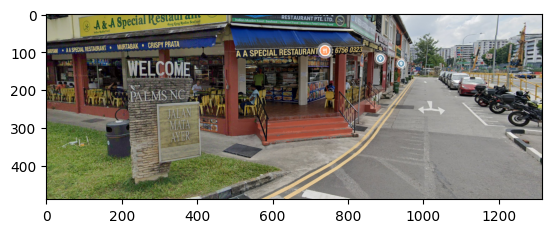

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[0.03713237]]
Hawker


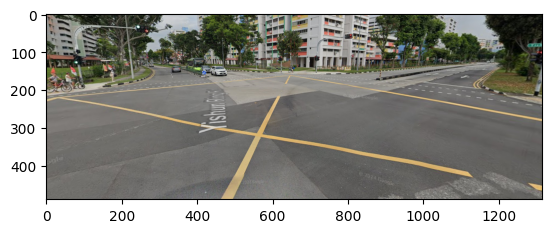

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[0.9952571]]
not hawker


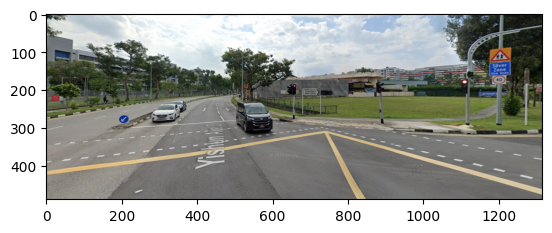

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[0.98838574]]
not hawker


In [60]:
for i in range(6):
    imagename = str(i)+ ".png"
    img = cv2.imread("Model Test/"+ imagename)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    resize = tf.image.resize(img,(256,256))
    #model takes in batch of images, use expand dims to batch single image
    yhat = model.predict(np.expand_dims(resize/255, 0))
    print(yhat)
    if yhat > 0.5:
        print("not hawker")
    else:
        print("Hawker")

Saving Model

In [61]:
from tensorflow.keras.models import load_model

In [63]:
model.save(os.path.join('models','HawkerClassifier.keras'))

In [ ]:
HawkerClassfierModel = load_model(os.path.join('models','HawkerClassifier.keras'))

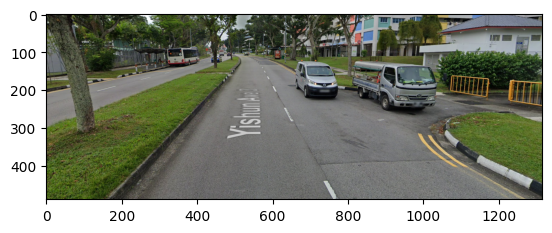

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[0.9991267]]
not hawker


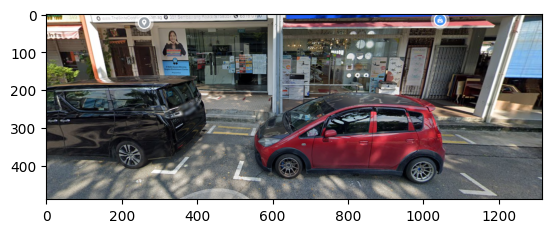

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[0.9976711]]
not hawker


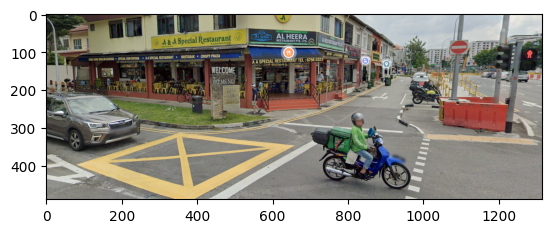

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[0.13099247]]
Hawker


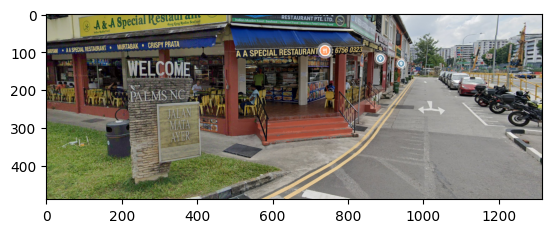

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[0.03713237]]
Hawker


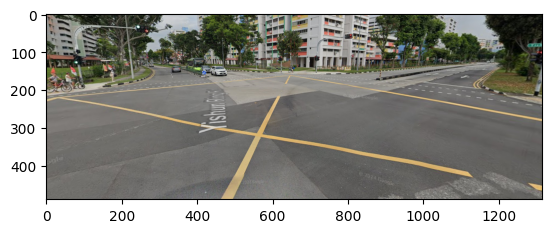

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[0.9952571]]
not hawker


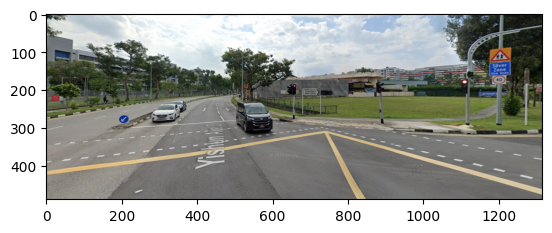

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[0.98838574]]
not hawker


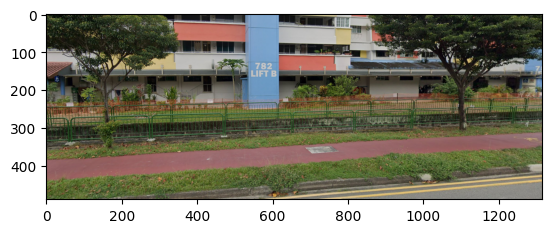

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[0.99789727]]
not hawker


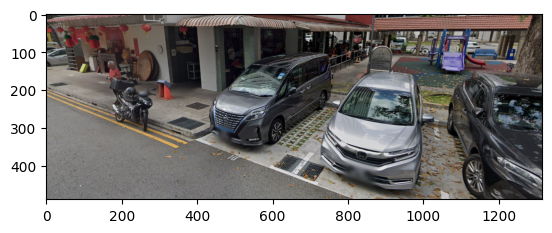

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[0.00391859]]
Hawker


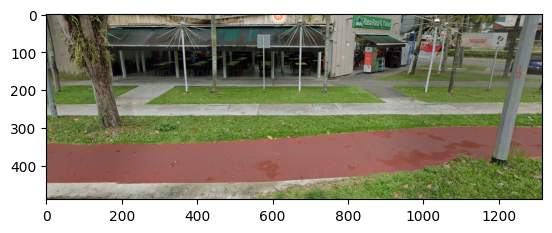

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[[0.16266453]]
Hawker


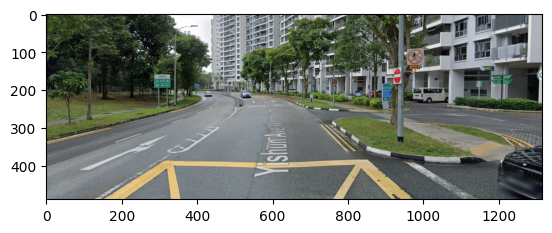

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[0.99862826]]
not hawker


In [68]:
for i in range(10):
    imagename = str(i)+ ".png"
    img = cv2.imread("Model Test/"+ imagename)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    resize = tf.image.resize(img,(256,256))
    #model takes in batch of images, use expand dims to batch single image
    yhat = HawkerClassfierModel.predict(np.expand_dims(resize/255, 0))
    print(yhat)
    if yhat > 0.5:
        print("not hawker")
    else:
        print("Hawker")